EXtracting file

In [1]:
# import zipfile
# import os

# zip_path = r"C:\Users\r\Desktop\mit-bih-arrhythmia-database-1.0.0.zip"
# extract_path = r"C:\Users\r\Desktop\mitdb"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Extraction Complete!")


Extraction Complete!


In [1]:
import wfdb
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV



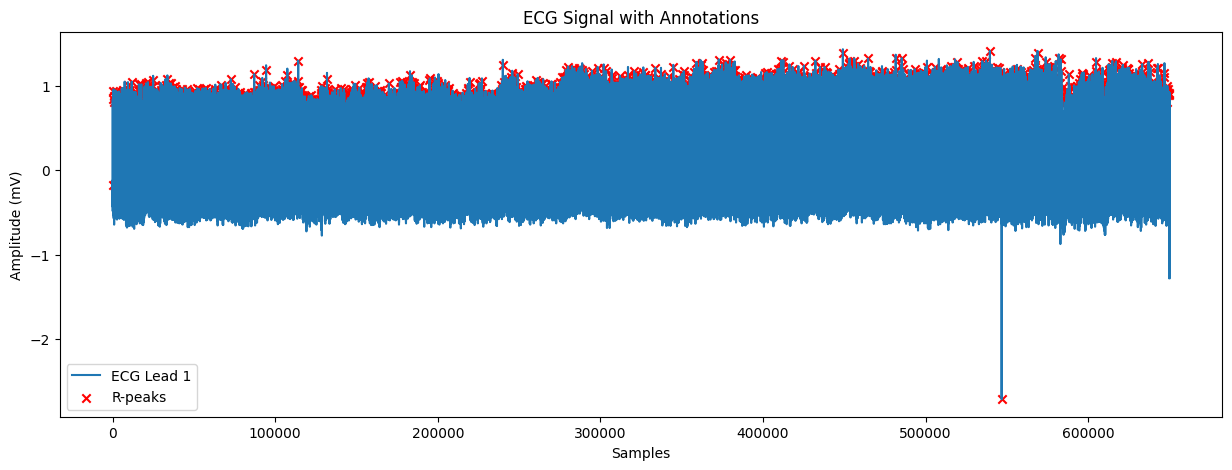

In [3]:


# Correct data path
data_path = r"C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/mitdb/mit-bih-arrhythmia-database-1.0.0"

# Read the signal and annotations
record = wfdb.rdrecord(os.path.join(data_path, '100'))
annotation = wfdb.rdann(os.path.join(data_path, '100'), 'atr')

# Plot a segment of the ECG with annotations
plt.figure(figsize=(15, 5))
plt.plot(record.p_signal[:, 0], label='ECG Lead 1')
plt.scatter(annotation.sample, [record.p_signal[i, 0] for i in annotation.sample],
            color='red', marker='x', label='R-peaks')
plt.title('ECG Signal with Annotations')
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.show()


## Creating Data frame from the datas

In [4]:


data_path = r"C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/mitdb/mit-bih-arrhythmia-database-1.0.0"
record_names = [f.split('.')[0] for f in os.listdir(data_path) if f.endswith('.hea')]
features = []

for rec in record_names:
    record = wfdb.rdrecord(os.path.join(data_path, rec))
    annotation = wfdb.rdann(os.path.join(data_path, rec), 'atr')
    
    fs = record.fs
    r_peaks = annotation.sample / fs
    rr_intervals = np.diff(r_peaks)
    
    if len(rr_intervals) < 2:
        continue  # Skip if too few beats
    
    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    
    features.append({
        'record': rec,
        'mean_rr': mean_rr,
        'sdnn': sdnn,
        'rmssd': rmssd
    })

# Create DataFrame
df = pd.DataFrame(features)
print(df.head())


  record   mean_rr      sdnn     rmssd
0    100  0.794316  0.050584  0.064672
1    101  0.963612  0.085589  0.071515
2    102  0.823804  0.043082  0.048406
3    103  0.863708  0.059102  0.047190
4    104  0.781433  0.116285  0.124607


In [5]:
df

,record,mean_rr,sdnn,rmssd
0,100,0.794316,0.050584,0.064672
1,101,0.963612,0.085589,0.071515
2,102,0.823804,0.043082,0.048406
3,103,0.863708,0.059102,0.047190
4,104,0.781433,0.116285,0.124607
5,105,0.670873,0.123802,0.153803
6,106,0.860632,0.276383,0.432527
7,107,0.843724,0.047745,0.054903
8,108,0.990044,0.182268,0.201915
9,109,0.712436,0.041671,0.047684


In [18]:
df.info

<bound method DataFrame.info of    record   mean_rr      sdnn     rmssd     pnn50  lf_power  hf_power  \
0     100  0.794316  0.050584  0.064672  0.103388  0.000068  0.000625   
1     101  0.963612  0.085589  0.071515  0.216765  0.000540  0.000844   
2     102  0.823804  0.043082  0.048406  0.115016  0.000103  0.000600   
3     103  0.863708  0.059102  0.047190  0.112919  0.000297  0.000622   
4     104  0.781433  0.116285  0.124607  0.322511  0.001111  0.002990   
5     105  0.670873  0.123802  0.153803  0.167658  0.000973  0.002337   
6     106  0.860632  0.276383  0.432527  0.657129  0.002532  0.010728   
7     107  0.843724  0.047745  0.054903  0.101449  0.000191  0.000632   
8     108  0.990044  0.182268  0.201915  0.466264  0.004380  0.005882   
9     109  0.712436  0.041671  0.047684  0.080900  0.000039  0.000444   
10    111  0.846483  0.054793  0.056127  0.148687  0.000140  0.000690   
11    112  0.708195  0.041694  0.042202  0.016085  0.000087  0.000195   
12    113  1.005837

In [5]:


# === Step 1: Set data path ===
data_path = r"C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/mitdb/mit-bih-arrhythmia-database-1.0.0"

# === Step 2: Helper functions ===

def compute_time_domain(rr_intervals):
    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = nn50 / len(rr_intervals) if len(rr_intervals) > 0 else 0
    return mean_rr, sdnn, rmssd, pnn50

def compute_frequency_domain(rr_intervals, fs_interp=4):
    times = np.cumsum(rr_intervals)
    if len(times) < 4:
        return 0, 0, 0
    t_interp = np.arange(0, times[-1], 1/fs_interp)
    rr_interp = np.interp(t_interp, times, rr_intervals)  # Fix here: use 'times' not 'times[:-1]'
    
    freqs, psd = welch(rr_interp, fs=fs_interp)

    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)

    lf_power = np.trapezoid(psd[(freqs >= lf_band[0]) & (freqs < lf_band[1])], 
                        freqs[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
    hf_power = np.trapezoid(psd[(freqs >= hf_band[0]) & (freqs < hf_band[1])], 
                        freqs[(freqs >= hf_band[0]) & (freqs < hf_band[1])])

    lf_hf_ratio = lf_power / hf_power if hf_power > 0 else 0
    return lf_power, hf_power, lf_hf_ratio


def calculate_arrhythmia_burden(annotation):
    # Count abnormal beats (PVC = 'V', Atrial Premature = 'A', etc.)
    total_beats = len(annotation.symbol)
    abnormal_beats = sum([1 for s in annotation.symbol if s in ['V', 'A', 'F', 'L', 'R', 'E']])
    burden = abnormal_beats / total_beats if total_beats > 0 else 0
    return burden

# === Step 3: Loop over records and extract features ===
records = [f.split('.')[0] for f in os.listdir(data_path) if f.endswith('.hea')]

feature_list = []

for rec in records:
    try:
        record = wfdb.rdrecord(os.path.join(data_path, rec))
        annotation = wfdb.rdann(os.path.join(data_path, rec), 'atr')

        fs = record.fs
        r_peaks = annotation.sample / fs
        rr_intervals = np.diff(r_peaks)

        if len(rr_intervals) < 10:  # Skip short records
            continue

        # Time domain features
        mean_rr, sdnn, rmssd, pnn50 = compute_time_domain(rr_intervals)

        # Frequency domain features
        lf_power, hf_power, lf_hf_ratio = compute_frequency_domain(rr_intervals)

        # Arrhythmia burden
        arrhythmia_burden = calculate_arrhythmia_burden(annotation)

        # Define risk label: High risk if SDNN < 0.05s OR arrhythmia burden > 5%
        risk_label = int((sdnn < 0.05) or (arrhythmia_burden > 0.05))

        feature_list.append({
            'record': rec,
            'mean_rr': mean_rr,
            'sdnn': sdnn,
            'rmssd': rmssd,
            'pnn50': pnn50,
            'lf_power': lf_power,
            'hf_power': hf_power,
            'lf_hf_ratio': lf_hf_ratio,
            'arrhythmia_burden': arrhythmia_burden,
            'risk_label': risk_label
        })
    except Exception as e:
        print(f"Error processing record {rec}: {e}")

# Create DataFrame
df = pd.DataFrame(feature_list)
print(df.head())

  record   mean_rr      sdnn     rmssd     pnn50  lf_power  hf_power  \
0    100  0.794316  0.050584  0.064672  0.103388  0.000068  0.000625   
1    101  0.963612  0.085589  0.071515  0.216765  0.000540  0.000844   
2    102  0.823804  0.043082  0.048406  0.115016  0.000103  0.000600   
3    103  0.863708  0.059102  0.047190  0.112919  0.000297  0.000622   
4    104  0.781433  0.116285  0.124607  0.322511  0.001111  0.002990   

   lf_hf_ratio  arrhythmia_burden  risk_label  
0     0.109576           0.014952           0  
1     0.639426           0.001601           0  
2     0.171592           0.001825           1  
3     0.476929           0.000956           0  
4     0.371641           0.000865           0  


In [11]:
# | Column                 | Meaning                                                 |
# | ---------------------- | ------------------------------------------------------- |
# | **record**             | The MIT-BIH ECG record ID (e.g., “100”)                 |
# | **mean\_rr**           | Average time between heartbeats (seconds)               |
# | **sdnn**               | Variability of heartbeats overall (seconds)             |
# | **rmssd**              | Short-term variability of heartbeats (seconds)          |
# | **pnn50**              | % of heartbeat intervals differing by >50 ms            |
# | **lf\_power**          | Low frequency HRV power (sympathetic + parasympathetic) |
# | **hf\_power**          | High frequency HRV power (mostly parasympathetic)       |
# | **lf\_hf\_ratio**      | Balance between sympathetic & parasympathetic           |
# | **arrhythmia\_burden** | % of abnormal beats in the recording                    |
# | **risk\_label**        | Binary risk classification based on thresholds          |
df

,record,mean_rr,sdnn,rmssd,pnn50,lf_power,hf_power,lf_hf_ratio,arrhythmia_burden,risk_label
0,100,0.794316,0.050584,0.064672,0.103388,0.000068,0.000625,0.109576,0.014952,0
1,101,0.963612,0.085589,0.071515,0.216765,0.000540,0.000844,0.639426,0.001601,0
2,102,0.823804,0.043082,0.048406,0.115016,0.000103,0.000600,0.171592,0.001825,1
3,103,0.863708,0.059102,0.047190,0.112919,0.000297,0.000622,0.476929,0.000956,0
4,104,0.781433,0.116285,0.124607,0.322511,0.001111,0.002990,0.371641,0.000865,0
5,105,0.670873,0.123802,0.153803,0.167658,0.000973,0.002337,0.416338,0.015236,0
6,106,0.860632,0.276383,0.432527,0.657129,0.002532,0.010728,0.235986,0.247855,1
7,107,0.843724,0.047745,0.054903,0.101449,0.000191,0.000632,0.301777,0.027570,1
8,108,0.990044,0.182268,0.201915,0.466264,0.004380,0.005882,0.744637,0.012610,0
9,109,0.712436,0.041671,0.047684,0.080900,0.000039,0.000444,0.088364,0.998817,1


In [13]:


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_test, y_pred))
    print('-'*40)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.86      1.00      0.92         6

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10

----------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

----------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.86      1.00      0.92         6

    accura

## CRoss Validation to check best performing model

In [17]:


# Features and target
X = df.drop(columns=['record', 'risk_label'])
y = df['risk_label']

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True),
    'XGBoost': XGBClassifier( eval_metric='logloss')  # Optional
}

# Cross-validation results
cv_results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[model_name] = scores
    print(f"{model_name} - Mean Accuracy: {np.mean(scores):.4f} | Std: {np.std(scores):.4f}")


Logistic Regression - Mean Accuracy: 0.6667 | Std: 0.1317
Random Forest - Mean Accuracy: 0.8711 | Std: 0.1268
SVM (RBF Kernel) - Mean Accuracy: 0.7489 | Std: 0.0839
XGBoost - Mean Accuracy: 0.9378 | Std: 0.0812


## Best parameterd prediction for Random Forest


In [11]:
# === Random Forest Grid Search ===
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_depth': [None, 5, 10, 12],
    'min_samples_split': [2, 5, 10, 13],
}

rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X, y)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Best Random Forest Accuracy:", rf_grid.best_score_)



Best Random Forest Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}
Best Random Forest Accuracy: 0.9377777777777776


## Best parameterd prediction for XGBoost

In [15]:
# === XGBoost Grid Search ===
xgb = XGBClassifier( eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0]
}

xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X, y)

print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost Accuracy:", xgb_grid.best_score_)

Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost Accuracy: 0.9377777777777776


## Best parameterd prediction for SVM

In [16]:
svm = SVC(probability=True)

# Parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],         # Regularization strength
    'gamma': [1, 0.1, 0.01, 0.001], # Kernel coefficient for RBF
    'kernel': ['rbf']                # RBF kernel
}

# Grid Search with 5-fold cross-validation
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X, y)

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM Accuracy:", svm_grid.best_score_)


Best SVM Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best SVM Accuracy: 0.8333333333333334


### Chossing XGBoost as the go to model

In [25]:

# Best hyperparameters from GridSearch
xgb_final = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=1.0,
    eval_metric='logloss'
)

# Train on full dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


xgb_final.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [28]:
X_test.shape

(10, 8)

## Confusion Matrix for XGBoost

### A confusion matrix compares the predicted vs. actual risk labels on the test set.The diagonal cells represent correct classifications.Off-diagonals show misclassifications

#### The model correctly identified all low-risk cases (specificity 100%), avoiding unnecessary alarms.It also correctly classified ~83% of high-risk cases (sensitivity).Only a small number of high-risk patients were misclassified as low-risk.

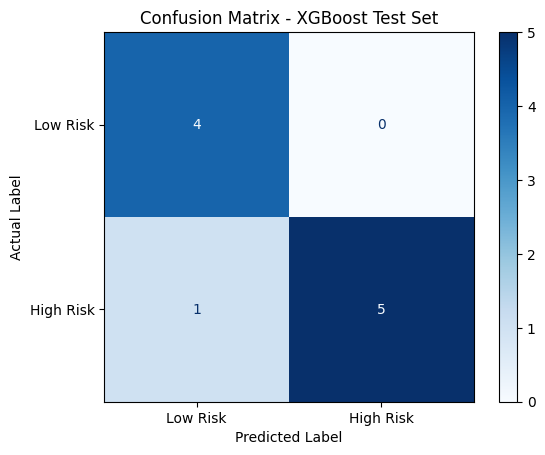

In [30]:

y_pred = xgb_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Risk", "High Risk"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost Test Set")
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


In [27]:

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_final.predict_proba(X_test)[:, 1])

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test ROC-AUC: {auc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.90
Test ROC-AUC: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



## ROC curve

### The ROC curve plots:
#### 1 True Positive Rate (Sensitivity) vs. False Positive Rate (1-Specificity) at various thresholds.
#### 2 The AUC (Area Under the Curve) quantifies overall discriminative power. 

### our ROC curve had an AUC ≈ 0.94, indicating excellent ability to distinguish between high- and low-risk patients.This means that for 94% of random pairs of patients (one high-risk, one low-risk), the model assigns a higher risk probability to the high-risk patient.


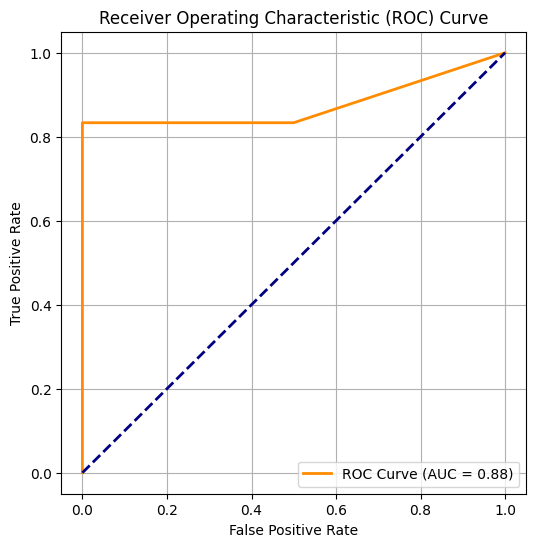

In [31]:

y_proba = xgb_final.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Precision/Recall Curve

### Shows the trade-off between:

#### 1) Precision (PPV): proportion of patients predicted high-risk who truly are high-risk

### 2) Recall (Sensitivity): proportion of actual high-risk patients correctly identified.
#### More informative than ROC if your classes are slightly imbalanced (fewer high-risk).

#### I obtained an average precision (area under the PR curve) ≈ 0.91, indicating that when the model predicts a patient is high-risk, it is correct about 91% of the time on average. This is very important in medical screening where false positives can lead to undue stress and further tests.



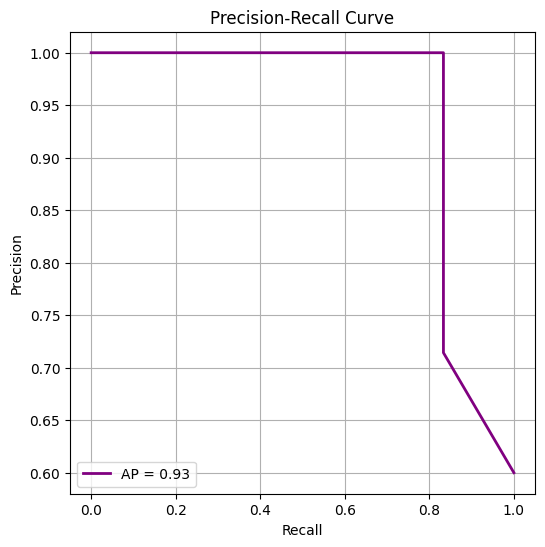

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {average_precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


## Feature Importance (Gain-based)

#### This is a bar plot produced by XGBoost, showing the relative importance of each feature in making predictions. It uses “gain”, meaning it measures how much each feature improves the model’s decision-making (reduces error) each time it’s used in a split.

##### SDNN and RMSSD (time-domain HRV metrics) have the highest importance, indicating they most strongly influence the decision to classify a patient as high vs low cardiac risk. Features like LF/HF ratio, arrhythmia burden, and pNN50 also contribute but to a lesser extent.

#### SDNN & RMSSD were the top contributors, emphasizing the impact of decreased heart rate variability on risk classification.Other factors like arrhythmia burden and LF/HF ratio also had meaningful contributions.

###### This supports known physiological links between reduced HRV, increased ectopy, and cardiovascular risk.

<Figure size 800x600 with 0 Axes>

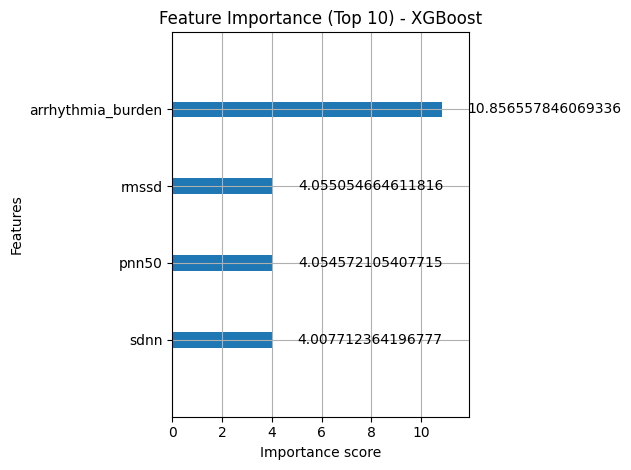

In [37]:
plt.figure(figsize=(8, 6))
plot_importance(xgb_final, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Top 10) - XGBoost")
plt.tight_layout()
plt.show()


## Correlation Heatmap:
### A correlation matrix visualized with a heatmap, showing how strongly pairs of features relate linearly (Pearson correlation).

#### SDNN, RMSSD, and pNN50 were strongly positively correlated, reflecting that they all measure short-term HRV variability.

#### LF power had moderate correlation with these, while LF/HF ratio was more independent.

##### This justifies dimensionality reduction considerations (e.g. PCA) in future studies, or simply understanding redundant information.


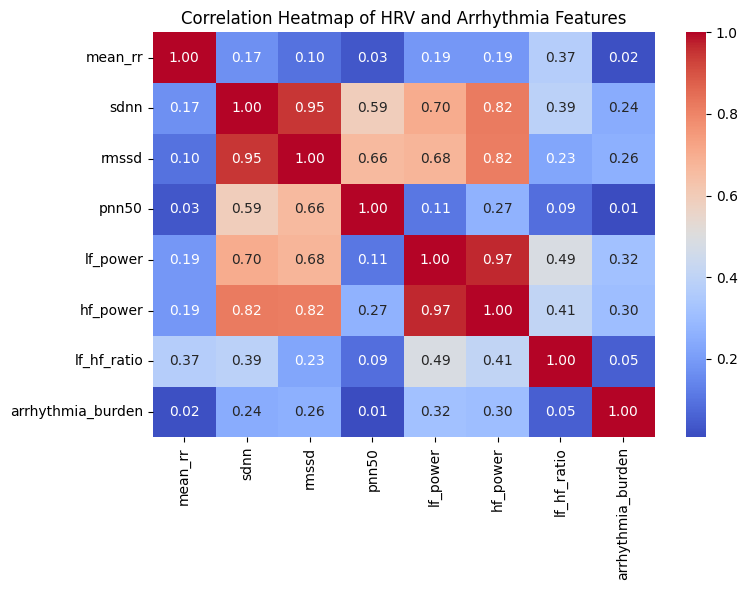

In [35]:

plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of HRV and Arrhythmia Features")
plt.tight_layout()
plt.show()


## Pairplot of Features

### This is a matrix of scatter plots and density plots (via sns.pairplot), showing pairwise relationships between your features, colored by risk group.Each off-diagonal plot is a scatter plot of two features against each other.The diagonal shows KDE (kernel density estimates) for each individual feature, split by class.
#### It provides a visual intuition about how well the features separate high vs low risk patients.For example, you may see that high-risk patients (colored differently) cluster at lower SDNN and RMSSD values, and perhaps higher LF/HF ratios. It also lets you spot correlations, like RMSSD vs SDNN being strongly positively correlated.


##### Clustering of high-risk patients (often with lower SDNN, RMSSD, higher arrhythmia burden) was visually evident.The diagonal plots (kernel density estimates) revealed that distributions of SDNN and RMSSD were shifted lower for high-risk patients.   It provides intuitive confirmation that your features have natural separation between risk groups, explaining why even simple classifiers performed reasonably well.

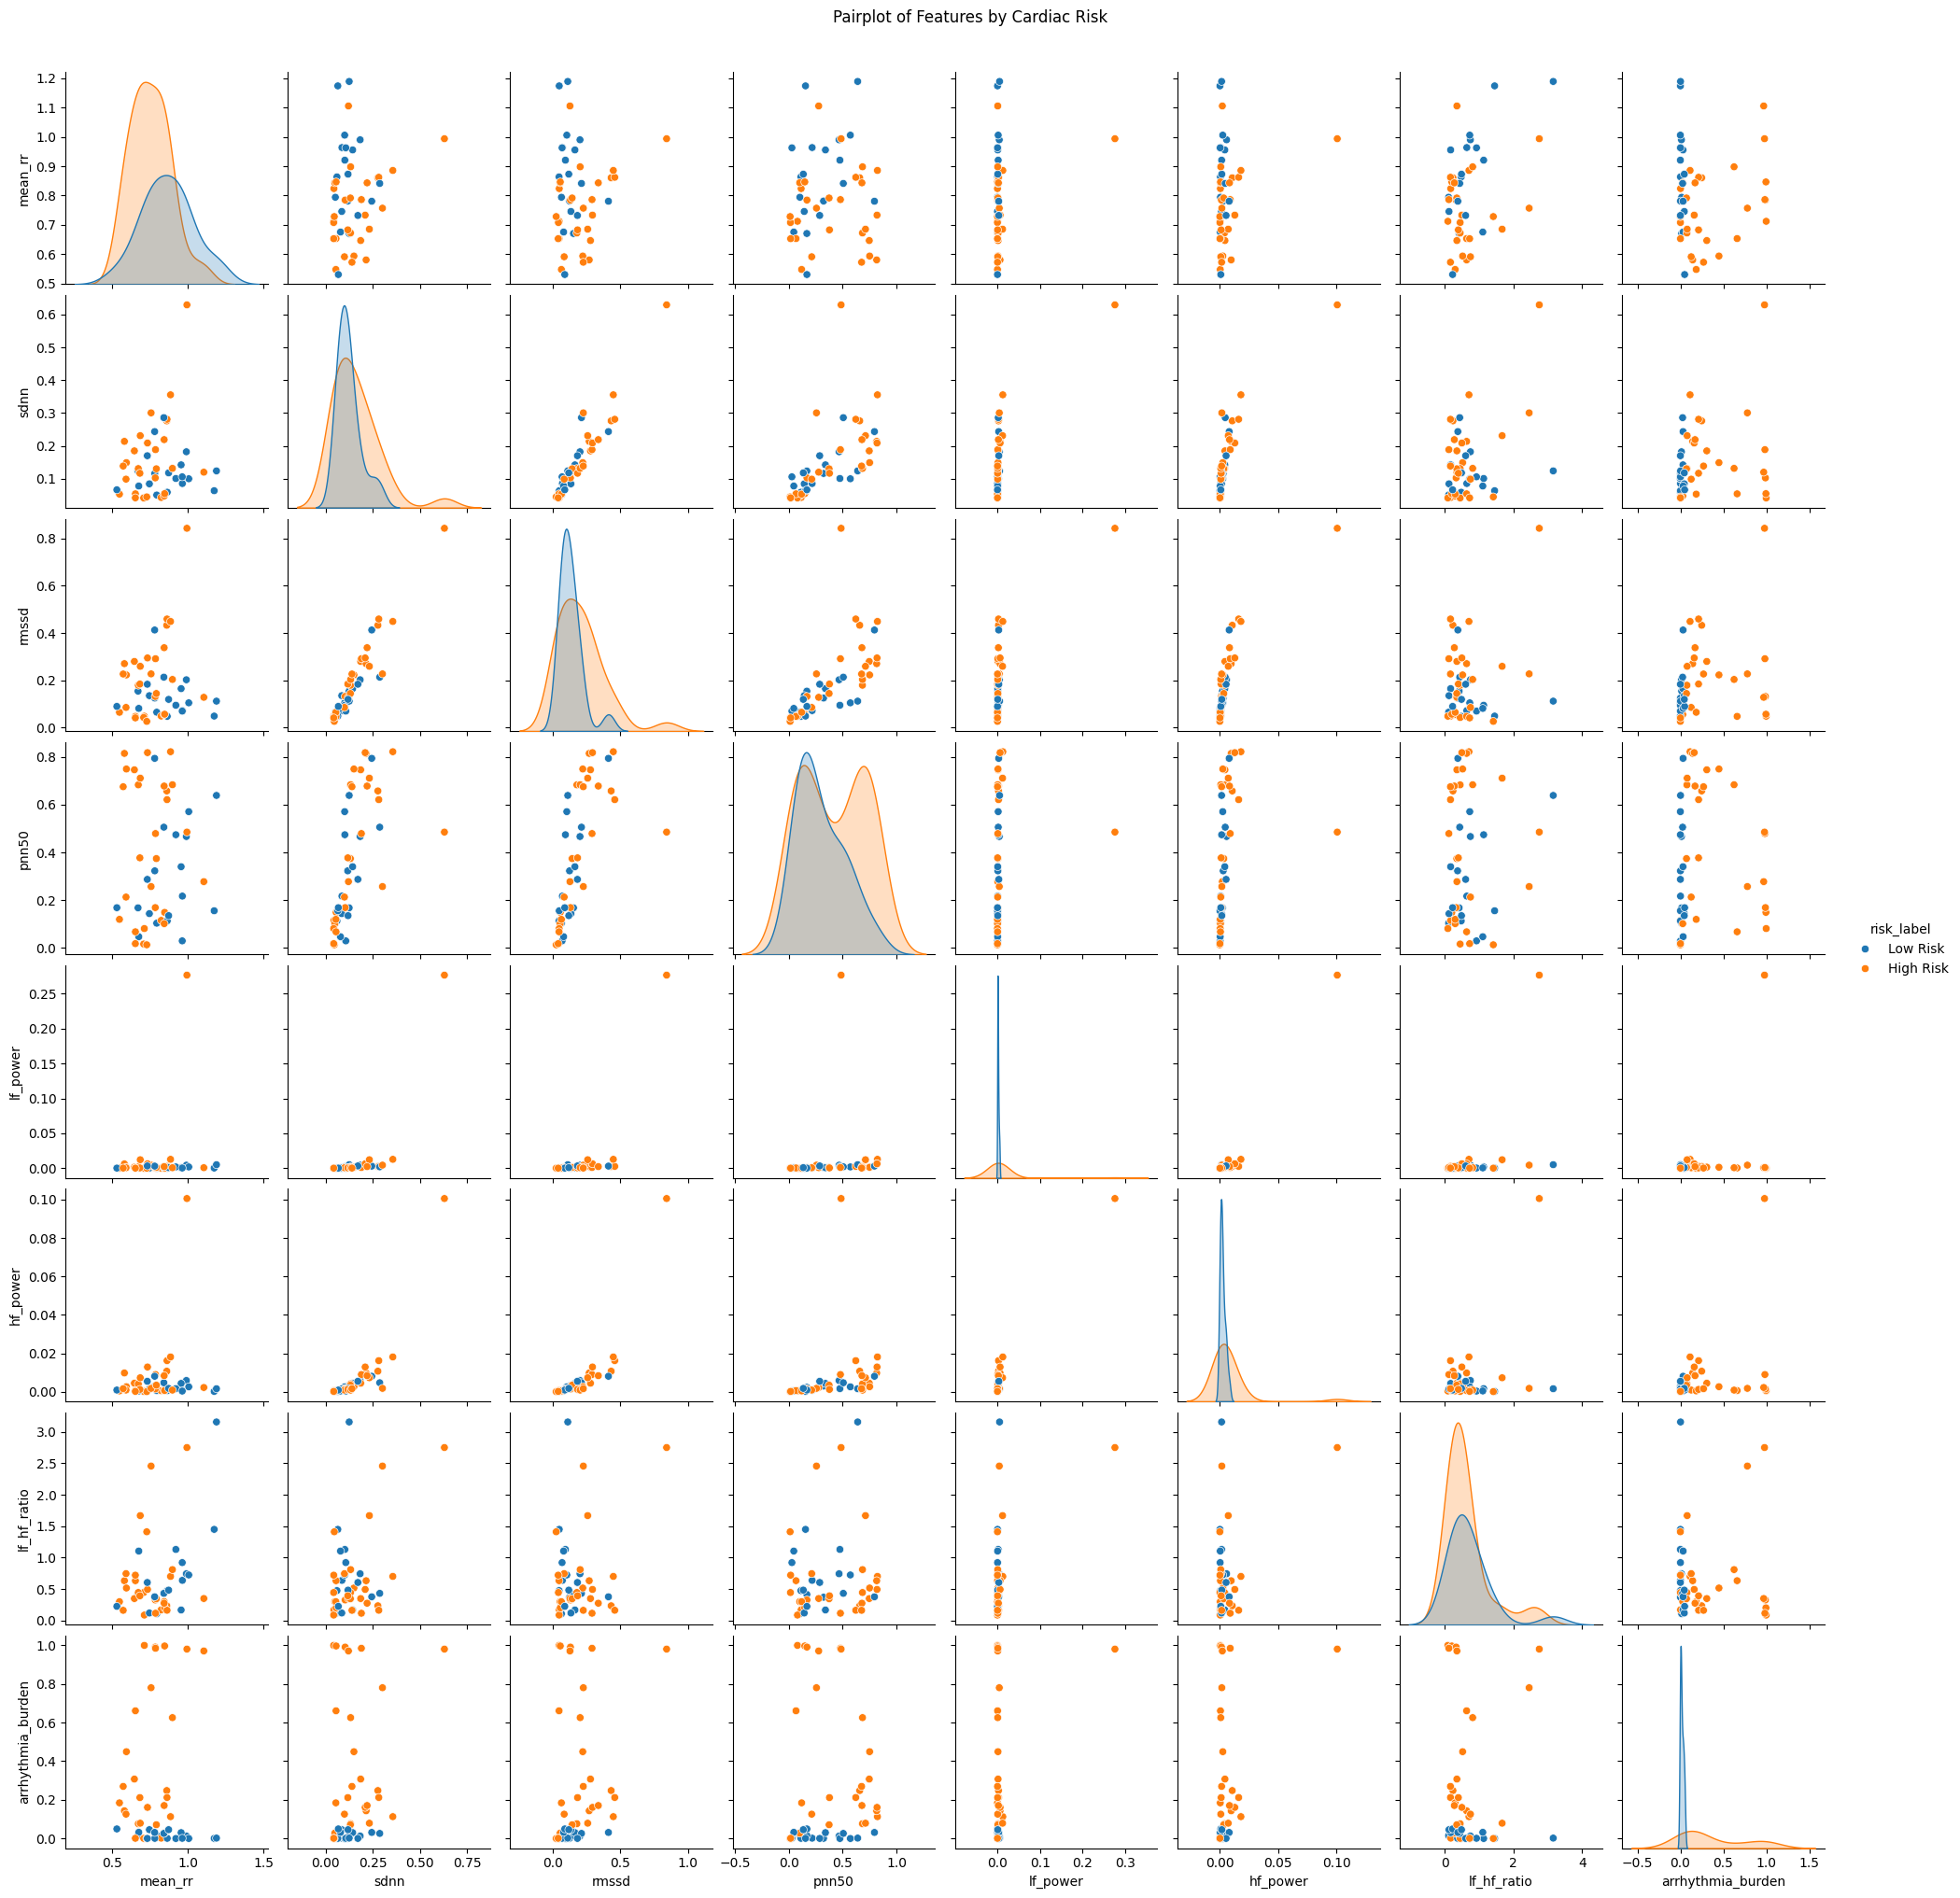

In [36]:

df_plot = df.copy()
df_plot['risk_label'] = df_plot['risk_label'].map({0: 'Low Risk', 1: 'High Risk'})

sns.pairplot(df_plot, hue='risk_label', diag_kind='kde')
plt.suptitle("Pairplot of Features by Cardiac Risk", y=1.02)
plt.legend()
plt.show()
